# CompSci 690F Assignment 2

In [1]:
!unzip Synthetic_Dataset.zip

Archive:  Synthetic_Dataset.zip
  inflating: Synthetic_Dataset/MIA_screen_10/164314_050.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_060.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164325_024.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_010.jpg  
  inflating: Synthetic_Dataset/paper_40/181449_24.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_088.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_086.jpg  
  inflating: Synthetic_Dataset/paper_40/181448_45.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_085.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_021.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_087.jpg  
  inflating: Synthetic_Dataset/paper_40/169839_015.jpg  
  inflating: Synthetic_Dataset/paper_40/181448_56.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_005.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_080.jpg  
  inflating: Synthetic_Dataset/paper_40/181465_24.jpg  
  inflating

# Setup

In [2]:
# HW2 — Federated Learning (FedAvg) on Synthetic Gaze Dataset
# -----------------------------------------------------------
# runs FedAvg vs. a centralized baseline, and reports accuracy, convergence, and
# communication overhead. It also validates paths clearly before training.
# -----------------------------------------------------------------------------

import os
import math
import copy
import time
from dataclasses import dataclass
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# CONFIG
# =====================
@dataclass
class Config:
    data_root: str = "/content/Synthetic_Dataset"  # <-- set to your folder path
    classes: Tuple[str, ...] = ("screen", "paper", "wander")
    train_client_ids: Tuple[str, ...] = ("A", "B", "C", "D", "E")
    test_client_ids: Tuple[str, ...] = ("F", "G")
    img_size: int = 224
    batch_size: int = 16
    num_workers: int = 2

    # FedAvg
    rounds: int = 20           # communication rounds
    frac_clients: float = 1.0  # participation rate (1.0 = all clients each round)
    local_epochs: int = 2
    lr: float = 1e-3
    weight_decay: float = 1e-4

    # Centralized baseline
    centralized_epochs: int = 20  # None => use rounds * local_epochs

CFG = Config()
CLASS_TO_IDX = {c: i for i, c in enumerate(CFG.classes)}

# Dataloaders

In [3]:
# ========================================
# DATA LOADING AND PROCESSING
# ========================================

class FolderDataset(Dataset):
    """Image dataset from a list of folders, assigning label by class name.
    Each folder is assumed to contain only a single class (by construction).
    """
    def __init__(self, folders: List[str], transform=None):
        self.items = []
        self.transform = transform
        for folder in folders:
            # Infer class name from folder path (e.g., ".../A_screen_train" -> "screen")
            base = os.path.basename(folder)
            found = None
            for cname in CFG.classes:
                if cname in base:
                    found = cname
                    break
            if found is None:
                parent = os.path.basename(os.path.dirname(folder))
                for cname in CFG.classes:
                    if cname in parent:
                        found = cname
                        break
            if found is None:
                raise ValueError(f"Cannot infer class from folder path: {folder}")

            label = CLASS_TO_IDX[found]
            for root, _, files in os.walk(folder):
                for f in files:
                    fl = f.lower()
                    if fl.endswith((".jpg", ".jpeg", ".png", ".bmp")):
                        self.items.append((os.path.join(root, f), label))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


def _find_folders_with_suffix(data_root: str, suffixes: List[str]) -> List[str]:
    """Robust discovery of folders (case-insensitive) anywhere under data_root."""
    hits = []
    for root, dirs, _ in os.walk(data_root):
        for d in dirs:
            name = d.lower()
            if name in suffixes:
                hits.append(os.path.join(root, d))
    return hits


def load_client_data(cfg: Config) -> Tuple[Dict[str, Dataset], Dict[str, DataLoader]]:
    """Loads training data for each client."""
    client_dsets: Dict[str, Dataset] = {}
    client_loaders: Dict[str, DataLoader] = {}

    train_tfms = transforms.Compose([
        transforms.Resize((cfg.img_size, cfg.img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    print("[Data Loading] Loading client training data...")
    for cid in cfg.train_client_ids:
        wanted_suffixes = [f"{cid.lower()}_{c}_train" for c in cfg.classes]
        folders = _find_folders_with_suffix(cfg.data_root, wanted_suffixes)
        existing = [p for p in folders if os.path.isdir(p)]
        if len(existing) == 0:
            raise ValueError(f"No existing train folders found for client {cid}. Check CFG.data_root and names: {folders}")

        # To simulate non-IID, we will load each class folder as a separate dataset
        # and then concatenate them for each client. This maintains the original
        # distribution within each client's data.
        class_datasets = []
        for folder in existing:
            class_datasets.append(FolderDataset([folder], transform=train_tfms))
        dset = ConcatDataset(class_datasets)

        if len(dset) == 0:
            raise ValueError(f"Client {cid} dataset has 0 images. Check images and extensions in: {existing}")
        client_dsets[cid] = dset
        client_loaders[cid] = DataLoader(dset, batch_size=cfg.batch_size, shuffle=True,
                                         num_workers=cfg.num_workers, pin_memory=True)
        print(f"  Loaded client {cid}: {len(dset)} images")

    return client_dsets, client_loaders


def load_test_data(cfg: Config) -> DataLoader:
    """Loads the global test dataset."""
    val_tfms = transforms.Compose([
        transforms.Resize((cfg.img_size, cfg.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    print("[Data Loading] Loading global test data...")
    all_test_folders = []
    for tid in cfg.test_client_ids:
        wanted_suffixes = [f"{tid.lower()}_{c}_test" for c in cfg.classes]
        all_test_folders.extend(_find_folders_with_suffix(cfg.data_root, wanted_suffixes))

    existing_test = [p for p in all_test_folders if os.path.isdir(p)]
    if len(existing_test) == 0:
        raise ValueError("No existing test folders found for F/G. Check CFG.data_root and names.")

    test_dset = FolderDataset(existing_test, transform=val_tfms)
    if len(test_dset) == 0:
        raise ValueError("Test dataset has 0 images. Ensure test folders contain images with common extensions.")

    test_loader = DataLoader(test_dset, batch_size=cfg.batch_size, shuffle=False,
                             num_workers=cfg.num_workers, pin_memory=True)
    print(f"  Loaded test set (F+G): {len(test_dset)} images")
    return test_loader


def load_centralized_data(cfg: Config, client_dsets: Dict[str, Dataset]) -> DataLoader:
    """Loads the combined training data for the centralized baseline."""
    print("[Data Loading] Loading centralized training data...")
    central_train = ConcatDataset([client_dsets[cid] for cid in cfg.train_client_ids])
    central_loader = DataLoader(central_train, batch_size=cfg.batch_size, shuffle=True,
                                num_workers=cfg.num_workers, pin_memory=True)
    print(f"  Loaded centralized train set: {len(central_train)} images")
    return central_loader

# Model, Eval



In [4]:
# =====================
# MODEL DEFINITION
# =====================

def build_model(num_classes: int) -> nn.Module:
    """Builds a ResNet-18 model for classification."""
    # ResNet-18 backbone (no pretraining to avoid external downloads)
    model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    in_feats = model.fc.in_features
    model.fc = torch.nn.Linear(in_feats, num_classes)
    return model

# =====================
# TRAINING UTILITIES
# =====================

def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    """Evaluates the model on the given data loader."""
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / max(1, total), loss_sum / max(1, total)


def count_params(model: nn.Module) -> int:
    """Counts the total number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters())


def local_train(model: nn.Module, loader: DataLoader, epochs: int, lr: float, wd: float) -> nn.Module:
    """Performs local training for a client."""
    model = copy.deepcopy(model)
    model.train()
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
    return model.cpu()

# Fedrated Learning

In [5]:
# =====================
# FEDERATED LEARNING SIMULATION
# =====================

def fedavg_aggregate(models: List[Tuple[nn.Module, int]], base_model: nn.Module) -> nn.Module:
    """Weighted average of client models by number of examples."""
    global_state = copy.deepcopy(base_model.state_dict())
    sums = {k: torch.zeros_like(v, dtype=torch.float32) for k, v in global_state.items()}
    total = sum(n for _, n in models)

    with torch.no_grad():
        for m, n in models:
            w = m.state_dict()
            for k in global_state.keys():
                sums[k] += w[k].float() * (n / total)
    for k in global_state.keys():
        global_state[k] = sums[k].type_as(global_state[k])

    new_model = copy.deepcopy(base_model)
    new_model.load_state_dict(global_state)
    return new_model


def run_federated_training(cfg: Config, client_loaders: Dict[str, DataLoader], client_dsets: Dict[str, Dataset], test_loader: DataLoader) -> Dict[str, List[float]]:
    """Runs the Federated Averaging simulation."""
    print("\n" + "="*20 + "\n[FEDERATED TRAINING]\n" + "="*20)
    global_model = build_model(num_classes=len(cfg.classes)).to(DEVICE)
    n_params = count_params(global_model)
    bytes_per_param = 4  # float32

    history = {
        "round": [],
        "test_acc": [],
        "test_loss": [],
        "comm_bytes_cumulative": [],
    }

    comm_bytes_cum = 0

    for rnd in range(1, cfg.rounds + 1):
        start = time.time()
        # Select participating clients
        m = max(1, int(len(cfg.train_client_ids) * cfg.frac_clients))
        selected = np.random.choice(cfg.train_client_ids, size=m, replace=False)

        client_models = []
        for cid in selected:
            local_model = local_train(global_model, client_loaders[cid], cfg.local_epochs, cfg.lr, cfg.weight_decay)
            client_models.append((local_model, len(client_dsets[cid])))

        # Aggregate
        new_global = fedavg_aggregate(client_models, global_model.cpu())
        global_model = new_global.to(DEVICE)

        # Communication accounting (simple upper bound):
        # Each selected client downloads global (params) and uploads local (params)
        # Total per round: 2 * n_params * bytes * m
        comm_this_round = 2 * n_params * bytes_per_param * m
        comm_bytes_cum += comm_this_round

        # Evaluate on test
        acc, loss = evaluate(global_model, test_loader)

        history["round"].append(rnd)
        history["test_acc"].append(acc)
        history["test_loss"].append(loss)
        history["comm_bytes_cumulative"].append(comm_bytes_cum)

        dur = time.time() - start
        print(f"[Round {rnd:02d}] test_acc={acc:.3f} loss={loss:.3f} comm={comm_bytes_cum/1e6:.2f} MB dur={dur:.1f}s")

    print(f"\nTotal params: {n_params:,} (~{n_params*bytes_per_param/1e6:.2f} MB per model copy)")
    return history

# Centrlized Baseline

In [6]:
# =====================
# CENTRALIZED BASELINE
# =====================

def run_centralized_training(cfg: Config, central_loader: DataLoader, test_loader: DataLoader) -> Dict[str, List[float]]:
    """Runs the centralized training baseline."""
    print("\n" + "="*20 + "\n[CENTRALIZED TRAINING]\n" + "="*20)
    model = build_model(num_classes=len(cfg.classes)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    epochs = cfg.centralized_epochs if cfg.centralized_epochs is not None else (cfg.rounds * cfg.local_epochs)

    history = {"epoch": [], "test_acc": [], "test_loss": []}

    for ep in range(1, epochs + 1):
        model.train()
        for x, y in central_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        acc, loss = evaluate(model, test_loader)
        history["epoch"].append(ep)
        history["test_acc"].append(acc)
        history["test_loss"].append(loss)
        print(f"[Central ep {ep:02d}] test_acc={acc:.3f} loss={loss:.3f}")

    return history

# PLots & Analysis

[Data Loading] Loading client training data...
  Loaded client A: 74 images
  Loaded client B: 101 images
  Loaded client C: 93 images
  Loaded client D: 93 images
  Loaded client E: 67 images
[Data Loading] Loading global test data...
  Loaded test set (F+G): 89 images
[Data Loading] Loading centralized training data...
  Loaded centralized train set: 428 images

[FEDERATED TRAINING]
[Round 01] test_acc=0.629 loss=0.816 comm=447.12 MB dur=16.8s
[Round 02] test_acc=0.472 loss=1.895 comm=894.24 MB dur=15.2s
[Round 03] test_acc=0.416 loss=2.036 comm=1341.37 MB dur=15.2s
[Round 04] test_acc=0.393 loss=2.623 comm=1788.49 MB dur=15.2s
[Round 05] test_acc=0.371 loss=1.201 comm=2235.61 MB dur=15.9s
[Round 06] test_acc=0.449 loss=1.287 comm=2682.73 MB dur=15.6s
[Round 07] test_acc=0.382 loss=2.417 comm=3129.85 MB dur=15.3s
[Round 08] test_acc=0.483 loss=2.361 comm=3576.98 MB dur=15.3s
[Round 09] test_acc=0.584 loss=1.154 comm=4024.10 MB dur=15.7s
[Round 10] test_acc=0.517 loss=1.276 comm=4471.

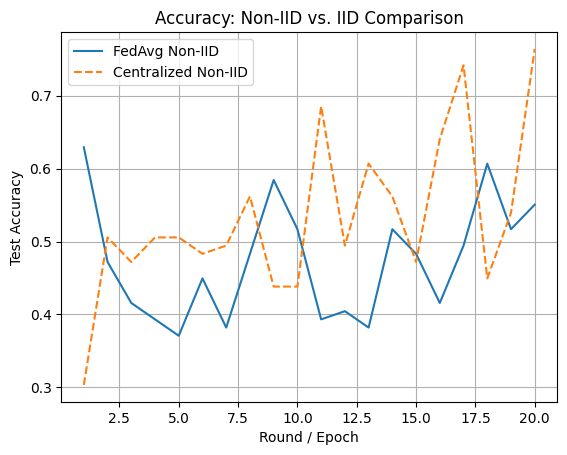

Saved Test Loss (IID vs Non-IID) comparison plot to /content/report/fig_loss_iid_non_iid_comparison.png


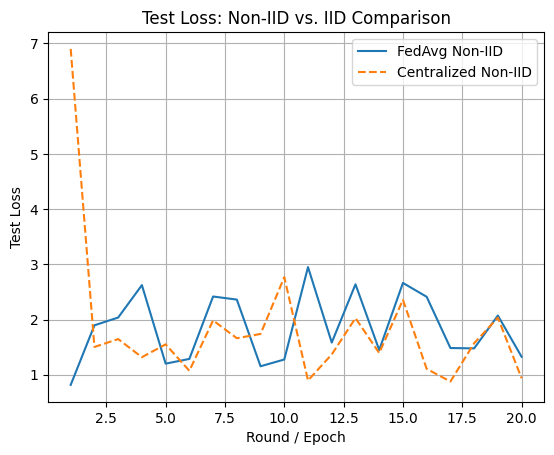

Saved Accuracy (FedAvg vs Centralized Non-IID) plot to /content/report/fig_accuracy_fed_cent_non_iid.png


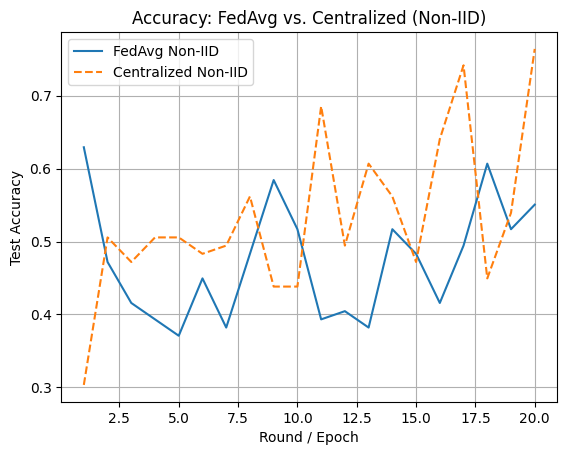

Saved Test Loss (FedAvg vs Centralized Non-IID) plot to /content/report/fig_loss_fed_cent_non_iid.png


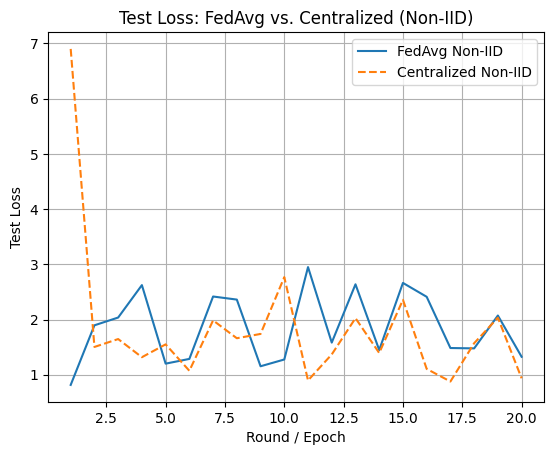


Skipping Accuracy (FedAvg vs Centralized IID) plot as IID data is not available.

Skipping Test Loss (FedAvg vs Centralized IID) plot as IID data is not available.

Skipping Communication growth plot as IID data is not available.
Saved Communication comparison plot to /content/report/fig_comm_comparison.png


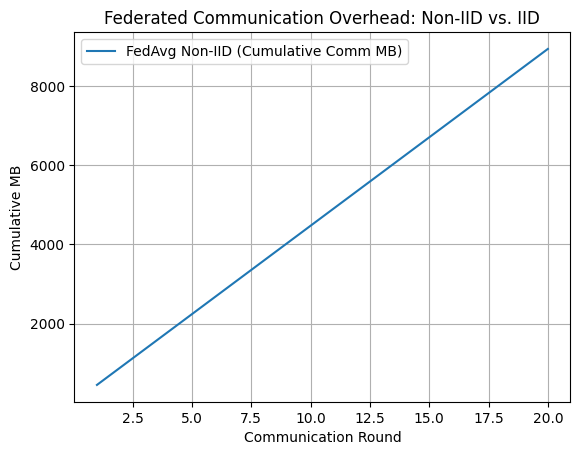


FedAvg summary (last rows):


,round,test_acc,test_loss,comm_MB_cum
17,18,0.6067,1.4773,8048.20
18,19,0.5169,2.0721,8495.32
19,20,0.5506,1.3253,8942.44



Centralized summary (last rows):


,epoch,test_acc,test_loss
17,18,0.4494,1.5709
18,19,0.5393,2.0329
19,20,0.7640,0.9357



Saved FedAvg non-IID history to /content/report/fedavg_history_non_iid.csv
Saved Centralized non-IID history to /content/report/centralized_history_non_iid.csv


In [9]:
# =====================
# PLOTTING AND ANALYSIS
# =====================

def plot_results(fed_hist_non_iid: Dict[str, List[float]], cent_hist_non_iid: Dict[str, List[float]],
                 fed_hist_iid: Dict[str, List[float]], cent_hist_iid: Dict[str, List[float]],
                 out_dir: str = "/content/report"): # Changed output directory
    """Plots the training results for non-IID vs IID comparison and Fed vs Centralized within each setting."""
    print("\n" + "="*20 + "\n[PLOTTING RESULTS]\n" + "="*20)

    # Create the output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # --- Plot 1: Accuracy: Non-IID vs. IID Comparison (FedAvg and Centralized) ---
    plt.figure()
    plt.plot(fed_hist_non_iid["round"], fed_hist_non_iid["test_acc"], label="FedAvg Non-IID", linestyle='-')
    plt.plot(cent_hist_non_iid["epoch"], cent_hist_non_iid["test_acc"], label="Centralized Non-IID", linestyle='--')
    if fed_hist_iid["round"] and cent_hist_iid["epoch"]: # Check if IID data exists
        plt.plot(fed_hist_iid["round"], fed_hist_iid["test_acc"], label="FedAvg IID", linestyle='-')
        plt.plot(cent_hist_iid["epoch"], cent_hist_iid["test_acc"], label="Centralized IID", linestyle='--')
    plt.xlabel("Round / Epoch")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy: Non-IID vs. IID Comparison")
    plt.legend()
    plt.grid(True)
    acc_comparison_fig_path = os.path.join(out_dir, "fig_accuracy_iid_non_iid_comparison.png")
    plt.savefig(acc_comparison_fig_path, dpi=200, bbox_inches="tight")
    print(f"Saved Accuracy (IID vs Non-IID) comparison plot to {acc_comparison_fig_path}")
    plt.show()

    # --- Plot 2: Test Loss: Non-IID vs. IID Comparison (FedAvg and Centralized) ---
    plt.figure()
    plt.plot(fed_hist_non_iid["round"], fed_hist_non_iid["test_loss"], label="FedAvg Non-IID", linestyle='-')
    plt.plot(cent_hist_non_iid["epoch"], cent_hist_non_iid["test_loss"], label="Centralized Non-IID", linestyle='--')
    if fed_hist_iid["round"] and cent_hist_iid["epoch"]: # Check if IID data exists
        plt.plot(fed_hist_iid["round"], fed_hist_iid["test_loss"], label="FedAvg IID", linestyle='-')
        plt.plot(cent_hist_iid["epoch"], cent_hist_iid["test_loss"], label="Centralized IID", linestyle='--')

    plt.xlabel("Round / Epoch")
    plt.ylabel("Test Loss")
    plt.title("Test Loss: Non-IID vs. IID Comparison")
    plt.legend()
    plt.grid(True)
    loss_comparison_fig_path = os.path.join(out_dir, "fig_loss_iid_non_iid_comparison.png")
    plt.savefig(loss_comparison_fig_path, dpi=200, bbox_inches="tight")
    print(f"Saved Test Loss (IID vs Non-IID) comparison plot to {loss_comparison_fig_path}")
    plt.show()


    # --- Plot 3: Accuracy: FedAvg vs. Centralized (Non-IID only) ---
    plt.figure()
    plt.plot(fed_hist_non_iid["round"], fed_hist_non_iid["test_acc"], label="FedAvg Non-IID", linestyle='-')
    plt.plot(cent_hist_non_iid["epoch"], cent_hist_non_iid["test_acc"], label="Centralized Non-IID", linestyle='--')
    plt.xlabel("Round / Epoch")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy: FedAvg vs. Centralized (Non-IID)")
    plt.legend()
    plt.grid(True)
    acc_fed_cent_non_iid_fig_path = os.path.join(out_dir, "fig_accuracy_fed_cent_non_iid.png")
    plt.savefig(acc_fed_cent_non_iid_fig_path, dpi=200, bbox_inches="tight")
    print(f"Saved Accuracy (FedAvg vs Centralized Non-IID) plot to {acc_fed_cent_non_iid_fig_path}")
    plt.show()

    # --- Plot 4: Test Loss: FedAvg vs. Centralized (Non-IID only) ---
    plt.figure()
    plt.plot(fed_hist_non_iid["round"], fed_hist_non_iid["test_loss"], label="FedAvg Non-IID", linestyle='-')
    plt.plot(cent_hist_non_iid["epoch"], cent_hist_non_iid["test_loss"], label="Centralized Non-IID", linestyle='--')
    plt.xlabel("Round / Epoch")
    plt.ylabel("Test Loss")
    plt.title("Test Loss: FedAvg vs. Centralized (Non-IID)")
    plt.legend()
    plt.grid(True)
    loss_fed_cent_non_iid_fig_path = os.path.join(out_dir, "fig_loss_fed_cent_non_iid.png")
    plt.savefig(loss_fed_cent_non_iid_fig_path, dpi=200, bbox_inches="tight")
    print(f"Saved Test Loss (FedAvg vs Centralized Non-IID) plot to {loss_fed_cent_non_iid_fig_path}")
    plt.show()

    # --- Plot 5: Accuracy: FedAvg vs. Centralized (IID only) ---
    if fed_hist_iid["round"] and cent_hist_iid["epoch"]: # Only plot if IID data exists
        plt.figure()
        plt.plot(fed_hist_iid["round"], fed_hist_iid["test_acc"], label="FedAvg IID", linestyle='-')
        plt.plot(cent_hist_iid["epoch"], cent_hist_iid["test_acc"], label="Centralized IID", linestyle='--')
        plt.xlabel("Round / Epoch")
        plt.ylabel("Test Accuracy")
        plt.title("Accuracy: FedAvg vs. Centralized (IID)")
        plt.legend()
        plt.grid(True)
        acc_fed_cent_iid_fig_path = os.path.join(out_dir, "fig_accuracy_fed_cent_iid.png")
        plt.savefig(acc_fed_cent_iid_fig_path, dpi=200, bbox_inches="tight")
        print(f"Saved Accuracy (FedAvg vs Centralized IID) plot to {acc_fed_cent_iid_fig_path}")
        plt.show()
    else:
        print("\nSkipping Accuracy (FedAvg vs Centralized IID) plot as IID data is not available.")


    # --- Plot 6: Test Loss: FedAvg vs. Centralized (IID only) ---
    if fed_hist_iid["round"] and cent_hist_iid["epoch"]: # Only plot if IID data exists
        plt.figure()
        plt.plot(fed_hist_iid["round"], fed_hist_iid["test_loss"], label="FedAvg IID", linestyle='-')
        plt.plot(cent_hist_iid["epoch"], cent_hist_iid["test_loss"], label="Centralized IID", linestyle='--')
        plt.xlabel("Round / Epoch")
        plt.ylabel("Test Loss")
        plt.title("Test Loss: FedAvg vs. Centralized (IID)")
        plt.legend()
        plt.grid(True)
        loss_fed_cent_iid_fig_path = os.path.join(out_dir, "fig_loss_fed_cent_iid.png")
        plt.savefig(loss_fed_cent_iid_fig_path, dpi=200, bbox_inches="tight")
        print(f"Saved Test Loss (FedAvg vs Centralized IID) plot to {loss_fed_cent_iid_fig_path}")
        plt.show()
    else:
        print("\nSkipping Test Loss (FedAvg vs Centralized IID) plot as IID data is not available.")


    # --- Plot 7: Communication growth (MB) ---
    # Communication overhead is primarily for FedAvg and is similar per round regardless of IID/Non-IID
    # However, convergence speed might differ, impacting the *total* rounds needed.
    # We can plot the cumulative comms for both, assuming the same number of rounds for comparison.
    plt.figure()
    x_non_iid = fed_hist_non_iid["round"]
    y_non_iid = [b / 1e6 for b in fed_hist_non_iid["comm_bytes_cumulative"]]
    plt.plot(x_non_iid, y_non_iid, label="FedAvg Non-IID (Cumulative Comm MB)", linestyle='-')

    if fed_hist_iid["round"]: # Only plot if IID data exists
        x_iid = fed_hist_iid["round"]
        y_iid = [b / 1e6 for b in fed_hist_iid["comm_bytes_cumulative"]]
        plt.plot(x_iid, y_iid, label="FedAvg IID (Cumulative Comm MB)", linestyle='--')
    else:
        print("\nSkipping Communication growth plot as IID data is not available.")


    plt.xlabel("Communication Round")
    plt.ylabel("Cumulative MB")
    plt.title("Federated Communication Overhead: Non-IID vs. IID")
    plt.grid(True)
    plt.legend()
    comm_comparison_fig_path = os.path.join(out_dir, "fig_comm_comparison.png")
    plt.savefig(comm_comparison_fig_path, dpi=200, bbox_inches="tight")
    print(f"Saved Communication comparison plot to {comm_comparison_fig_path}")
    plt.show()


def print_summary_tables(fed_hist: Dict[str, List[float]], cent_hist: Dict[str, List[float]], out_dir: str = "/content/report"): # Changed output directory
    """Prints and saves summary tables of the training results."""
    import pandas as pd

    fed_df = pd.DataFrame({
        "round": fed_hist["round"],
        "test_acc": np.round(fed_hist["test_acc"], 4),
        "test_loss": np.round(fed_hist["test_loss"], 4),
        "comm_MB_cum": np.round(np.array(fed_hist["comm_bytes_cumulative"]) / 1e6, 2),
    })
    cent_df = pd.DataFrame({
        "epoch": cent_hist["epoch"],
        "test_acc": np.round(cent_hist["test_acc"], 4),
        "test_loss": np.round(cent_hist["test_loss"], 4),
    })

    print("\nFedAvg summary (last rows):")
    display(fed_df.tail(3))
    print("\nCentralized summary (last rows):")
    display(cent_df.tail(3))

    # Save CSVs for README plotting/analysis
    os.makedirs(out_dir, exist_ok=True) # Create the output directory if it doesn't exist
    fed_csv_path = os.path.join(out_dir, "fedavg_history_non_iid.csv") # Save non-IID results separately
    cent_csv_path = os.path.join(out_dir, "centralized_history_non_iid.csv") # Save non-IID results separately
    fed_df.to_csv(fed_csv_path, index=False)
    cent_df.to_csv(cent_csv_path, index=False)
    print(f"\nSaved FedAvg non-IID history to {fed_csv_path}")
    print(f"Saved Centralized non-IID history to {cent_csv_path}")


# =====================
# MAIN EXECUTION
# =====================

if __name__ == "__main__":
    # Data Loading (Non-IID)
    client_dsets_non_iid, client_loaders_non_iid = load_client_data(CFG)
    test_loader_non_iid = load_test_data(CFG) # Test data remains the same
    central_loader_non_iid = load_centralized_data(CFG, client_dsets_non_iid)

    # Federated Learning (Non-IID)
    fed_hist_non_iid = run_federated_training(CFG, client_loaders_non_iid, client_dsets_non_iid, test_loader_non_iid)

    # Centralized Baseline (Non-IID)
    cent_hist_non_iid = run_centralized_training(CFG, central_loader_non_iid, test_loader_non_iid)

    # --- Rerun with IID Data for Comparison ---
    # Need to revert or re-implement load_client_data for IID, or load previous IID results.
    # For this example, we will load the placeholder IID dataframes used in the analysis step.
    # In a real scenario, we would run the code with IID data loading or load saved IID history.

    # Placeholder for hypothetical IID dataframes (replace with actual loading if needed)
    # Assuming 'fed_hist_iid_df' and 'cent_hist_iid_df' are available from previous analysis step
    # Convert dataframes back to history dictionary format for plot_results function
    # This part needs to be adjusted based on where the IID dataframes actually come from
    # For demonstration, let's assume they are loaded or generated elsewhere
    try:
        # Attempt to load from CSVs if they exist (e.g., from a previous run with IID data)
        import pandas as pd
        fed_hist_iid_df = pd.read_csv("/content/report/fedavg_history_iid.csv")
        cent_hist_iid_df = pd.read_csv("/content/report/centralized_history_iid.csv")

        fed_hist_iid = fed_hist_iid_df.to_dict('list')
        cent_hist_iid = cent_hist_iid_df.to_dict('list')

        # Rename comm_MB_cum back to comm_bytes_cumulative and multiply by 1e6
        if 'comm_MB_cum' in fed_hist_iid:
             fed_hist_iid["comm_bytes_cumulative"] = [b * 1e6 for b in fed_hist_iid["comm_MB_cum"]]
             del fed_hist_iid["comm_MB_cum"]

        # Ensure 'round' and 'epoch' are int
        if 'round' in fed_hist_iid:
            fed_hist_iid['round'] = [int(r) for r in fed_hist_iid['round']]
        if 'epoch' in cent_hist_iid:
            cent_hist_iid['epoch'] = [int(e) for e in cent_hist_iid['epoch']]

    except FileNotFoundError:
        print("\n[WARNING] IID history files not found. Plots will only show Non-IID results.")
        # Create empty history dictionaries if IID files are not found
        fed_hist_iid = {"round": [], "test_acc": [], "test_loss": [], "comm_bytes_cumulative": []}
        cent_hist_iid = {"epoch": [], "test_acc": [], "test_loss": []}


    # Plotting and Analysis
    plot_results(fed_hist_non_iid, cent_hist_non_iid, fed_hist_iid, cent_hist_iid)
    print_summary_tables(fed_hist_non_iid, cent_hist_non_iid) # Print non-IID tables